In [53]:
from __future__ import print_function
import torch.backends.cudnn as cudnn
import torch
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

import argparse
import os
import random
import sys
import pprint
import datetime
import dateutil
import dateutil.tz
from shutil import copyfile

from PIL import Image
import pickle
import matplotlib.pyplot as plt
#dir_path = (os.path.abspath(os.path.join(os.path.realpath(__file__), './.')))
#sys.path.append(dir_path)

from miscc.datasets import TextDataset
from miscc.config import cfg, cfg_from_file
from miscc.utils import mkdir_p
from trainer import GANTrainer

import torch.backends.cudnn as cudnn
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import os
import time

import numpy as np
import torchfile
import torchvision
from miscc.config import cfg
from miscc.utils import mkdir_p
from miscc.utils import weights_init
from miscc.utils import save_img_results, save_model
from miscc.utils import compute_discriminator_loss, compute_generator_loss
from miscc.utils import compute_transformation_matrix, compute_transformation_matrix_inverse
from miscc.utils import load_validation_data, pad_imgs

from tensorboard import summary
from tensorboard import FileWriter

In [54]:
from model import STAGE1_G

In [55]:
NET_G_path = 'models/model-multi-mnist-0019.pth'

DATA_DIR = 'Multi-MNIST/test/'

In [56]:
def load_network_stageI():
    from model import STAGE1_G
    netG = STAGE1_G()
    netG.apply(weights_init)

    state_dict = torch.load(NET_G_path, map_location={'cuda:0': 'cpu'})
    netG.load_state_dict(state_dict["netG"])
    
    return netG#, netD

In [57]:
def sample(datapath, num_samples=25, draw_bbox=True, num_digits_per_img=3, change_bbox_size=False):

    img_dir = os.path.join(datapath, "normal", "imgs/")
    netG = load_network_stageI()
    netG.eval()
    test_set_size = 10000

    label, bbox = load_validation_data(datapath)

    if num_digits_per_img < 3:
        label = label[:, :num_digits_per_img, :]
        bbox = bbox[:, :num_digits_per_img, ...]
    elif num_digits_per_img > 3:
        def get_one_hot(targets, nb_classes):
            res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
            return res.reshape(list(targets.shape) + [nb_classes])

        labels_sample = np.random.randint(0, 10, size=(bbox.shape[0], num_digits_per_img-3))
        labels_sample = get_one_hot(labels_sample, 10)
        labels_new = np.zeros((label.shape[0], num_digits_per_img, 10))
        labels_new[:, :3, :] = label
        labels_new[:, 3:, :] = labels_sample
        label = torch.from_numpy(labels_new)

        bboxes_x = np.random.random((bbox.shape[0], num_digits_per_img-3, 1))
        bboxes_y = np.random.random((bbox.shape[0], num_digits_per_img-3, 1))
        bboxes_w = np.random.randint(10, 20, size=(bbox.shape[0], num_digits_per_img-3, 1)) / 64.0
        bboxes_h = np.random.randint(16, 20, size=(bbox.shape[0], num_digits_per_img-3, 1)) / 64.0

        bbox_new_concat = np.concatenate((bboxes_x, bboxes_y, bboxes_w, bboxes_h), axis=2)
        bbox_new = np.zeros([bbox.shape[0], num_digits_per_img, 4])
        bbox_new[:, :3, :] = bbox
        bbox_new[:, 3:, :] = bbox_new_concat
        bbox = torch.from_numpy(bbox_new)

    if change_bbox_size:
        bbox_idx = np.random.randint(0, bbox.shape[1])
        scale_x = np.random.random(bbox.shape[0])
        scale_x[scale_x < 0.5] = 0.5
        scale_y = np.random.random(bbox.shape[0])
        scale_y[scale_y < 0.5] = 0.5

        bbox[:, bbox_idx, 2] *= torch.from_numpy(scale_x)
        bbox[:, bbox_idx, 3] *= torch.from_numpy(scale_y)

    filepath = os.path.join(datapath, "normal", 'filenames.pickle')
    with open(filepath, 'rb') as f:
        filenames = pickle.load(f)

    label_one_hot = label.float()

    #######################################
    bbox_ = bbox.clone()
    bbox = bbox.view(-1, 4)
    transf_matrices_inv = compute_transformation_matrix_inverse(bbox).float()
    transf_matrices_inv = transf_matrices_inv.view(test_set_size, num_digits_per_img, 2, 3)
    #######################################

    nz = 100#cfg.Z_DIM
    noise = Variable(torch.FloatTensor(9, nz))
    if False:#cfg.CUDA:
        noise = noise.cuda()

    imsize = 64

    for count in range(num_samples):

        index = int(np.random.randint(0, test_set_size, 1))
        key = filenames[index].split("/")[-1]
        img_name = img_dir + key
        img = Image.open(img_name)
        val_image = torchvision.transforms.functional.to_tensor(img)
        val_image = val_image.view(1, 1, imsize, imsize)
        val_image = (val_image - 0.5) * 2

        transf_matrices_inv_batch = transf_matrices_inv[index]
        label_one_hot_batch = label_one_hot[index]

        transf_matrices_inv_batch = transf_matrices_inv_batch.view(1, num_digits_per_img, 2, 3).repeat(9, 1, 1, 1)
        label_one_hot_batch = label_one_hot_batch.view(1, num_digits_per_img, 10).repeat(9, 1, 1)

        if False:#cfg.CUDA:
            label_one_hot_batch = label_one_hot_batch.cuda()

        #######################################################
        # (2) Generate fake images
        ######################################################
        noise.data.normal_(0, 1)

        _, fake_imgs = netG(noise, transf_matrices_inv_batch, label_one_hot_batch,num_digits_per_img)

        data_img = torch.FloatTensor(10, 1, imsize, imsize).fill_(0)
        data_img[0] = val_image
        data_img[1:10] = fake_imgs

        if True: #draw_bbox:
            for idx in range(num_digits_per_img):
                x, y, w, h = tuple([int(imsize*x) for x in bbox_[index, idx]])
                w = imsize-1 if w > imsize-1 else w
                h = imsize-1 if h > imsize-1 else h
                while x + w >= 64:
                    x -= 1
                    w -= 1
                while y + h >= 64:
                    y -= 1
                    h -= 1
                if x <= -1:
                    break
            
                data_img[:10, :, y, x:x + w] = 1
                data_img[:10, :, y:y + h, x] = 1
                data_img[:10, :, y+h, x:x + w] = 1
                data_img[:10, :, y:y + h, x + w] = 1
                
                ### CREATE SEGMENTATION
                _, label_digit = np.where(label_one_hot_batch[idx])
                tmp = data_img[0, :, y+1:y+h,x+1:x+w]
                tmp[tmp>0] = label_digit[idx]*0.1+0.1
                data_img[0, :, y+1:y+h,x+1:x+w] = tmp

        # write digit identities into image
        if False:#text:
            text_img = Image.new('L', (imsize*10, imsize), color = 'white')
            d = ImageDraw.Draw(text_img)
            label = label_one_hot_batch[0]
            label = label.cpu().numpy()
            label = np.argmax(label, axis=1)
            label = ", ".join([str(label[_]) for _ in range(num_digits_per_img)])
            d.text((10,10), label)
            text_img = torchvision.transforms.functional.to_tensor(text_img)
            text_img = torch.chunk(text_img, 10, 2)
            text_img = torch.cat([text_img[i].view(1, 1, imsize, imsize) for i in range(10)], 0)
            data_img[10:] = text_img
        return data_img

        #vutils.save_image(data_img, '{}/vis_{}.png'.format(save_dir, count), normalize=True, nrow=10)
    #print("Saved {} files to {}".format(count+1, save_dir))

In [60]:
data_img = sample(DATA_DIR,num_digits_per_img=3)

/Users/frederikwarburg/anaconda3/envs/pyspark/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


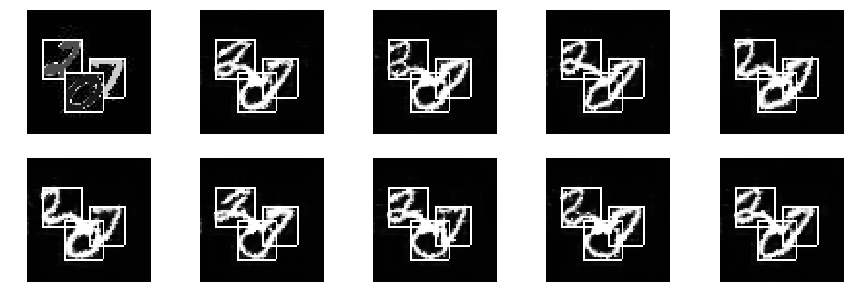

In [61]:
images = data_img.detach().numpy()
images = (images*255).astype(np.uint8)

plt.figure(figsize=(15,5))
for c,im in enumerate(images):
    plt.subplot(2,5,c+1)
    
    stacked_img = np.stack((im[0,:,:],)*3, axis=-1)
    plt.imshow(stacked_img)
    plt.axis('off')